In [2]:
import os

In [3]:
#Fix randomness and hide warnings
seed = 69420

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

In [6]:
import numpy as np
np.random.seed(seed)

In [7]:
import logging

In [8]:
import random
random.seed(seed)

In [9]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
#print(tf.__version__)

In [10]:
# Import other libraries
#import cv2
#from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
print("Finished loading libraries")

Finished loading libraries


In [13]:
model_name = "CNN_2_Dropout"

In [14]:
class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, model_name))

    def predict(self, X):
        
        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        out = self.model.predict(X)
        out = tf.argmax(out, axis=-1)  # Shape [BS]

        return out

In [15]:
def show_images(images):
    # Show all images in in images array. Make a scrollable window if there are more than 50 images and display them in a grid
    num_images = len(images)    # Number of images
    num_cols = int(np.ceil(np.sqrt(num_images)))    # Number of columns in the grid
    num_rows = int(np.ceil(num_images / num_cols))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

In [16]:
def plot_results(history):
    """ print("Plotting results...")
    # Plot the training
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15,5))
    plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show() """

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history['val_accuracy'])

    # Plot training and validation performance metrics
    plt.figure(figsize=(20, 5))

    # Plot training and validation loss
    plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
    plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=0.3)

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy, highlighting the best epoch
    plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
    plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
    plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=0.3)

    plt.show()

In [17]:
print("Training model...")
# Load images from the .npz file
data_path = 'public_data.npz'
data = np.load(data_path, allow_pickle=True)

images = data['data']
labels = data['labels']

i = 0
for image in images: 
    # Normalize image pixel values to a float range [0, 1]
    images[i] = (images[i] / 255).astype(np.float32)
    # Convert image from BGR to RGB
    images[i] = images[i][...,::-1]
    i = i+1
    if (i % 1000 == 0):
        print("Processing image: ", i)
print("Finished processing images")

# ------------------------------------------
# Display images to check if correctly loaded

display_images = False
if display_images:
    show_images(images)

# ------------------------------------------
labels = np.array(labels) #TODO: Check if needed

labels = LabelEncoder().fit_transform(labels)
labels = tfk.utils.to_categorical(labels,len(np.unique(labels)))

# Use the stratify option to maintain the class distribution in the train and test datasets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, stratify=np.argmax(labels, axis=1), random_state=seed)

# Further split the test set into test and validation sets, stratifying the labels
images_test, images_val, labels_test, labels_val = train_test_split(images_test, labels_test, test_size=0.5, stratify=np.argmax(labels_test, axis=1), random_state=seed)

print("\n\nSHAPES OF THE SETS:\n")

print(f"images_train shape: {images_train.shape}, labels_train shape: {labels_train.shape}")
print(f"images_val shape: {images_val.shape}, labels_val shape: {labels_val.shape}")
print(f"images_test shape: {images_test.shape}, labels_test shape: {labels_test.shape}")

print("\n\n")

# ------------------------------------------
# Define input shape, output shape, batch size, and number of epochs
input_shape = images_train.shape[1:]
output_shape = labels_train.shape[1:]
batch_size = 32
epochs = 1000

# Print input shape, batch size, and number of epochs
#print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")
# ------------------------------------------

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True, mode='auto'),
]

dropout_rate = 0.1

# INSERT AUGMENTATION HERE

def build_model(input_shape=input_shape, output_shape=output_shape, dropout_rate = dropout_rate):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dropout(rate=dropout_rate, name='dropout')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

model = build_model()
model.summary()
#tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

# Train the model
history = model.fit(
    x = images_train,
    y = labels_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (images_val, labels_val),
    callbacks = callbacks
).history

model.save(model_name)

# ------------------------------------------
plot_result = True
if plot_result:
    plot_results(history)
# ------------------------------------------



Training model...
Processing image:  1000
Processing image:  2000
Processing image:  3000
Processing image:  4000
Processing image:  5000
Finished processing images


SHAPES OF THE SETS:

images_train shape: (4160, 96, 96, 3), labels_train shape: (4160, 2)
images_val shape: (520, 96, 96, 3), labels_val shape: (520, 2)
images_test shape: (520, 96, 96, 3), labels_test shape: (520, 2)





Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0       

KeyboardInterrupt: 

Predictions Shape: (520, 2)
Accuracy: 0.8212
Precision: 0.8173
Recall: 0.7994
F1: 0.8061


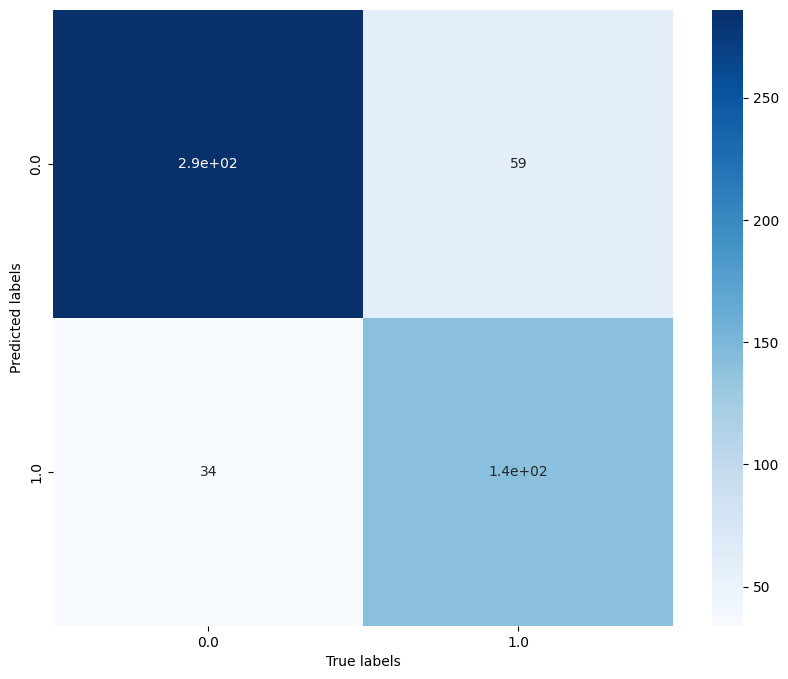

In [ ]:
evaluate = True
if evaluate:
    # Evaluate the model on the test set
    # Copilot generated version:
    # test_loss, test_acc = model.evaluate(images_test, labels_test, verbose=2)

    # Notebooks version:
    # Predict labels for the entire test set
    predictions = model.predict(images_test, verbose=0)

    # Display the shape of the predictions
    print("Predictions Shape:", predictions.shape)

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(labels_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute classification metrics
    accuracy = accuracy_score(np.argmax(labels_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(labels_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(labels_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(labels_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

    # Display the computed metrics
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))

    print("\n0:Healthy, 1:Unhealthy\n")
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm.T, annot=True, xticklabels=np.unique(labels_test), yticklabels=np.unique(labels_test), cmap='Blues')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

Red quantity:  tf.Tensor(3854.6582, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3094.0918, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3569.8848, shape=(), dtype=float32)
Red quantity:  tf.Tensor(4022.7524, shape=(), dtype=float32)
Red quantity:  tf.Tensor(4028.0579, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3740.302, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3916.143, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3411.2812, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3551.9731, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3721.1228, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3819.1348, shape=(), dtype=float32)
Red quantity:  tf.Tensor(4710.9453, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3897.1558, shape=(), dtype=float32)
Red quantity:  tf.Tensor(3462.4, shape=(), dtype=float32)
Red quantity:  tf.Tensor(4011.9016, shape=(), dtype=float32)
Red quantity:  tf.Tensor(4003.7148, shape=(), dtype=float32)
Red quantity:  tf.Tensor(2981

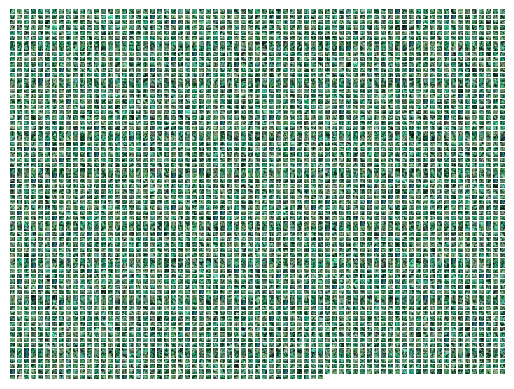

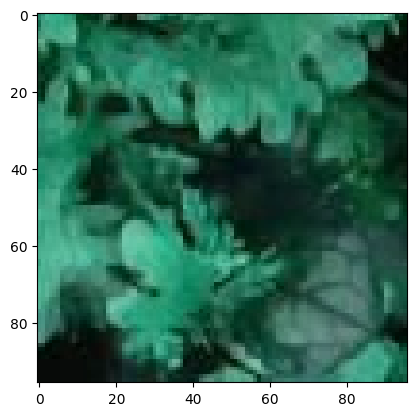

In [35]:
""" green_threshold = 2000  # Adjust the threshold as needed """
# if filtered_images exists, then delete it
if 'filtered_images' in globals():
    del filtered_images
# Function to calculate the overall green quantity in an image
""" def calculate_green_quantity(image):
    # Convert the image to the HSV color space
    hsv_image = tf.image.rgb_to_hsv(image)

    # Extract the green channel (Hue value for green)
    green_channel = hsv_image[:, :, 1]

    # Calculate the overall green quantity
    green_quantity = tf.reduce_sum(green_channel)
    #print("Green quantity: ", green_quantity)
    # add green quantity to a list
    #green_quantities.append(green_quantity)
    return green_quantity  """

red_threshold = 4750
def calculate_red_quantity(image):
    # Convert the image to the HSV color space
    hsv_image = tf.image.rgb_to_hsv(image)

    # Extract the red channel (Hue value for red)
    red_channel = hsv_image[:, :, 0]

    # Calculate the overall red quantity
    red_quantity = tf.reduce_sum(red_channel)
    print("Red quantity: ", red_quantity)
    return red_quantity

# Filter images based on the green quantity
filtered_images = [image for image in images if calculate_red_quantity(image) < red_threshold]

red_quantities = []
for image in images:
    red_quantities.append(calculate_red_quantity(image))

# print the average, min and max values in green_quantities
print("Average red quantity: ", np.mean(red_quantities))
print("Min red quantity: ", np.min(red_quantities))
print("Max red quantity: ", np.max(red_quantities))

# print the len of images
print("Number of images: ", len(images))
num_images = len(filtered_images)    # Number of images
print("Number of filtered images: ", num_images)
num_cols = int(np.ceil(np.sqrt(num_images)))    # Number of columns in the grid
num_rows = int(np.ceil(num_images / num_cols))    # Number of rows in the grid
#num_img = 50    # Number of images to display in the window at a time
# Show the images
show_images = True
if show_images:
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(filtered_images[i])
        plt.axis('off')
    plt.ion()
    plt.show()

#plot image 266
plt.subplot(1,1,1)
plt.imshow(images[267])
plt.show()

In [50]:
# Reload images from the .npz file
data_path = 'public_data.npz'
data = np.load(data_path, allow_pickle=True)

images = data['data']
labels = data['labels']

In [52]:
positions_to_remove = [58, 95, 137, 138, 171, 207, 338, 412, 434, 486, 506, 529, 571, 
                           599, 622, 658, 692, 701, 723, 725, 753, 779, 783, 827, 840, 880, 
                           898, 901, 961, 971, 974, 989, 1028, 1044, 1064, 1065, 1101, 1149, 
                           1172, 1190, 1191, 1265, 1268, 1280, 1333, 1384, 1443, 1466, 1483, 
                           1528, 1541, 1554, 1594, 1609, 1630, 1651, 1690, 1697, 1752, 1757,
                           1759, 1806, 1828, 1866, 1903, 1938, 1939, 1977, 1981, 1988, 2022, 
                           2081, 2090, 2150, 2191, 2192, 2198, 2261, 2311, 2328, 2348, 2380, 
                           2426, 2435, 2451, 2453, 2487, 2496, 2515, 2564, 2581, 2593, 2596, 
                           2663, 2665, 2675, 2676, 2727, 2734, 2736, 2755, 2779, 2796, 2800, 
                           2830, 2831, 2839, 2864, 2866, 2889, 2913, 2929, 2937, 3033, 3049, 
                           3055, 2086, 3105, 3108, 3144, 3155, 3286, 3376, 3410, 3436, 3451,
                           3488, 3490, 3572, 3583, 3666, 3688, 3700, 3740, 3770, 3800, 3801, 
                           3802, 3806, 3811, 3821, 3835, 3862, 3885, 3896, 3899, 3904, 3927, 
                           3931, 3946, 3950, 3964, 3988, 3989, 4049, 4055, 4097, 4100, 4118, 
                           4144, 4150, 4282, 4310, 4314, 4316, 4368, 4411, 4475, 4476, 4503,
                           4507, 4557, 4605, 4618, 4694, 4719, 4735, 4740, 4766, 4779, 4837,
                           4848, 4857, 4860, 4883, 4897, 4903, 4907, 4927, 5048, 5080, 5082, 
                           5121, 5143, 5165, 5171]
print("Len of positions_to_remove: ", len(positions_to_remove))
n = 0
for pos in positions_to_remove:
    new_pos = pos - n
    print("Removing image at position: ", pos, " - New Position is ", new_pos)
    images = np.delete(images, new_pos, axis=0)
    labels = np.delete(labels, new_pos, axis=0)
    n = n + 1

Len of positions_to_remove:  196
Removing image at position:  58  - New Position is  58
Removing image at position:  95  - New Position is  94
Removing image at position:  137  - New Position is  135
Removing image at position:  138  - New Position is  135
Removing image at position:  171  - New Position is  167
Removing image at position:  207  - New Position is  202
Removing image at position:  338  - New Position is  332
Removing image at position:  412  - New Position is  405
Removing image at position:  434  - New Position is  426
Removing image at position:  486  - New Position is  477
Removing image at position:  506  - New Position is  496
Removing image at position:  529  - New Position is  518
Removing image at position:  571  - New Position is  559
Removing image at position:  599  - New Position is  586
Removing image at position:  622  - New Position is  608
Removing image at position:  658  - New Position is  643
Removing image at position:  692  - New Position is  676
Re

KeyboardInterrupt: 

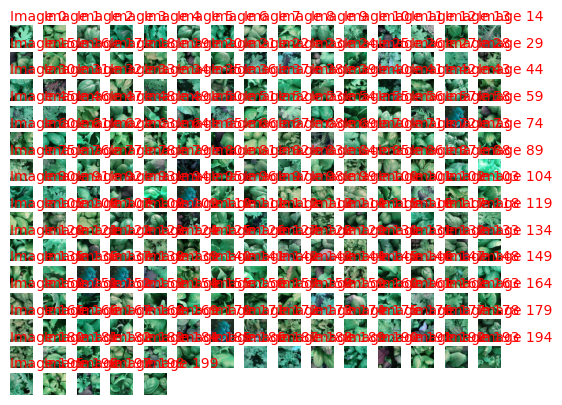

In [46]:
""" for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(filtered_images[i])
        plt.axis('off')
plt.ion()
plt.show() """
num_images = 200
num_cols = int(np.ceil(np.sqrt(num_images)))    # Number of columns in the grid
num_rows = int(np.ceil(num_images / num_cols))    # Number of rows in the grid
# for i in range from 500 to 600

num_images = 200
num_cols = int(np.ceil(np.sqrt(num_images)))    # Number of columns in the grid
num_rows = int(np.ceil(num_images / num_cols))    # Number of rows in the grid
range_min = 0
range_max = 500

for i in range(range_min, range_max):
    plt.subplot(num_rows, num_cols, i+1 - range_min)
    plt.imshow(images[i])
    plt.axis('off')
    plt.text(0, -20, f"Image {i}", fontsize=10, color='red')
plt.show()